# Sleep Machine Learning

Welcome to my Unsupervised machine learning project. On this project I'll be analyzing a particular dataset, my very own sleep.
The data was and is continously being gathered from my Fitbit focusing specifically on my Activity and Sleep patterns. If you want to gather your own data with fitbit you can do so [here](https://help.fitbit.com/articles/en_US/Help_article/1133.htm?Highlight=TCX%20file) and if you want to check this analysis you can check it on my GitHub repo online [rorrostieta/Sleep](https://github.com/rorrostieta/Sleep).

The factors that I want to study in this case are what contributes to me having a long and good sleep time and more specifically see if my activity throughout the day has any sort of impact into how I manage to sleep.

Lets begin the project with some pre-liminary set up and exploratory data analysis (EDA)

**Plotly is highly encouraged to be able to load the visualizations, you can see visualization on the video presentation**
## Libraries

In [453]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

## Exploratory Data Analysis
On this part we can see some of the features to be fed into the model, on a very first approach since we see this have time series I'm going to remove them to avoid adding more complexity to the problem. One of the advantages of being the one gathering the data is that it looks mostly clean but some information is missing, in this case we can dimiss that row which could be attributed to me not wearing the Fitbit to sleep.

In [454]:
data = pd.read_csv('./data/SleepData_Fitbit.csv', skiprows=1)
data.head()

,Date,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Start Time,End Time,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep
0,2021-12-01,"2,281","2,737",2.02,7,677,150,0,0,585,2021-12-01 10:37 PM,2021-12-02 6:54 AM,416.0,81.0,25.0,497.0,135.0,177.0,104.0
1,2021-12-02,"2,504","4,090",3.01,8,758,176,9,0,777,2021-12-02 10:50 PM,2021-12-03 7:18 AM,445.0,62.0,29.0,507.0,105.0,263.0,77.0
2,2021-12-03,"2,223","2,006",1.48,5,814,119,0,0,434,2021-12-03 11:54 PM,2021-12-04 8:29 AM,458.0,57.0,32.0,515.0,126.0,269.0,63.0
3,2021-12-04,"2,772","8,510",6.27,43,718,137,23,47,"1,104",2021-12-05 3:10 AM,2021-12-05 9:56 AM,338.0,68.0,14.0,406.0,99.0,160.0,79.0
4,2021-12-05,"2,178","2,873",2.12,9,916,110,7,1,477,2021-12-05 8:48 PM,2021-12-06 5:21 AM,467.0,46.0,33.0,513.0,140.0,238.0,89.0


In [455]:
drop_columns = ['Date','Start Time', 'End Time']
interest_data = data.drop(drop_columns, axis=1)
interest_data.replace(',','',regex=True, inplace=True)
interest_data = interest_data.apply(pd.to_numeric)

In [456]:
interest_data.isna().sum()

Calories Burned           0
Steps                     0
Distance                  0
Floors                    0
Minutes Sedentary         0
Minutes Lightly Active    0
Minutes Fairly Active     0
Minutes Very Active       0
Activity Calories         0
Minutes Asleep            1
Minutes Awake             1
Number of Awakenings      1
Time in Bed               1
Minutes REM Sleep         1
Minutes Light Sleep       1
Minutes Deep Sleep        1
dtype: int64

In [457]:
interest_data.dropna(axis=0, inplace=True)

### Target Variable
After this step of the data cleaning procedure I'll define a "target" for the data, in this case this target would be composed of how many times I slept more than 7 hours, this will be relevant for any visualization or model where the target would be important to point out.

<AxesSubplot:>

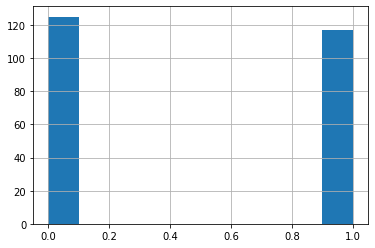

In [458]:
target = interest_data['Minutes REM Sleep'] + interest_data['Minutes Light Sleep'] + interest_data['Minutes Deep Sleep']
target = (target > 420).astype(int) #Slept More than 7 hours
target.hist()

### Correlations
After cleaning the data lets see a correlation matrix to see which features might be correlated and try to drop the ones that give really similar information. My initial thought is that **Calories Burned** will be correlated with most of the activity features and we might be able to drop a lot of those.

In [459]:
corr = interest_data.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep
Calories Burned,1.000,0.901,0.899,0.641,-0.701,0.757,0.685,0.537,0.983,-0.057,-0.038,0.042,-0.060,0.027,-0.148,0.126
Steps,0.901,1.000,0.997,0.776,-0.691,0.689,0.627,0.581,0.922,-0.063,-0.106,0.036,-0.083,0.029,-0.161,0.152
Distance,0.899,0.997,1.000,0.779,-0.680,0.670,0.611,0.601,0.916,-0.061,-0.108,0.035,-0.082,0.031,-0.161,0.151
Floors,0.641,0.776,0.779,1.000,-0.455,0.312,0.484,0.672,0.635,-0.096,-0.098,-0.039,-0.111,-0.026,-0.144,0.086
Minutes Sedentary,-0.701,-0.691,-0.680,-0.455,1.000,-0.691,-0.518,-0.251,-0.767,0.089,0.033,0.074,0.088,0.075,0.139,-0.145
Minutes Lightly Active,0.757,0.689,0.670,0.312,-0.691,1.000,0.284,-0.043,0.811,-0.059,-0.018,0.093,-0.057,0.057,-0.164,0.116
Minutes Fairly Active,0.685,0.627,0.611,0.484,-0.518,0.284,1.000,0.489,0.690,0.010,-0.056,0.037,-0.005,0.037,-0.052,0.099
Minutes Very Active,0.537,0.581,0.601,0.672,-0.251,-0.043,0.489,1.000,0.484,-0.008,-0.065,-0.061,-0.023,-0.041,-0.029,0.120
Activity Calories,0.983,0.922,0.916,0.635,-0.767,0.811,0.690,0.484,1.000,-0.044,-0.053,0.054,-0.052,0.039,-0.145,0.151
Minutes Asleep,-0.057,-0.063,-0.061,-0.096,0.089,-0.059,0.010,-0.008,-0.044,1.000,0.297,0.591,0.971,0.696,0.730,0.499


In [460]:
drop_columns_two = ['Calories Burned', 'Steps', 'Distance', 'Activity Calories', 'Time in Bed', 'Minutes Asleep']
interest_data = interest_data.drop(drop_columns_two, axis=1)
features = interest_data.columns

As expected we see that a lot of the activity features are correlated between each other so we defined a couple we could get rid of and rerun the correlation. The second time we run the correlation matrix we see that we significantly reduced the amount of correlation between the features to have a much more reliable model avoiding colinearity.

In [461]:
corr = interest_data.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Minutes Awake,Number of Awakenings,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep
Floors,1.000,-0.455,0.312,0.484,0.672,-0.098,-0.039,-0.026,-0.144,0.086
Minutes Sedentary,-0.455,1.000,-0.691,-0.518,-0.251,0.033,0.074,0.075,0.139,-0.145
Minutes Lightly Active,0.312,-0.691,1.000,0.284,-0.043,-0.018,0.093,0.057,-0.164,0.116
Minutes Fairly Active,0.484,-0.518,0.284,1.000,0.489,-0.056,0.037,0.037,-0.052,0.099
Minutes Very Active,0.672,-0.251,-0.043,0.489,1.000,-0.065,-0.061,-0.041,-0.029,0.120
Minutes Awake,-0.098,0.033,-0.018,-0.056,-0.065,1.000,0.120,-0.074,0.449,0.045
Number of Awakenings,-0.039,0.074,0.093,0.037,-0.061,0.120,1.000,0.452,0.393,0.330
Minutes REM Sleep,-0.026,0.075,0.057,0.037,-0.041,-0.074,0.452,1.000,0.115,0.487
Minutes Light Sleep,-0.144,0.139,-0.164,-0.052,-0.029,0.449,0.393,0.115,1.000,-0.053
Minutes Deep Sleep,0.086,-0.145,0.116,0.099,0.120,0.045,0.330,0.487,-0.053,1.000


Now lets look at the distribution of the data with histograms of each of the remaining features to see if there are any skewed data we need to fix in order to feed the model good quality information.

array([[<AxesSubplot:title={'center':'Floors'}>,
        <AxesSubplot:title={'center':'Minutes Sedentary'}>,
        <AxesSubplot:title={'center':'Minutes Lightly Active'}>],
       [<AxesSubplot:title={'center':'Minutes Fairly Active'}>,
        <AxesSubplot:title={'center':'Minutes Very Active'}>,
        <AxesSubplot:title={'center':'Minutes Awake'}>],
       [<AxesSubplot:title={'center':'Number of Awakenings'}>,
        <AxesSubplot:title={'center':'Minutes REM Sleep'}>,
        <AxesSubplot:title={'center':'Minutes Light Sleep'}>],
       [<AxesSubplot:title={'center':'Minutes Deep Sleep'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

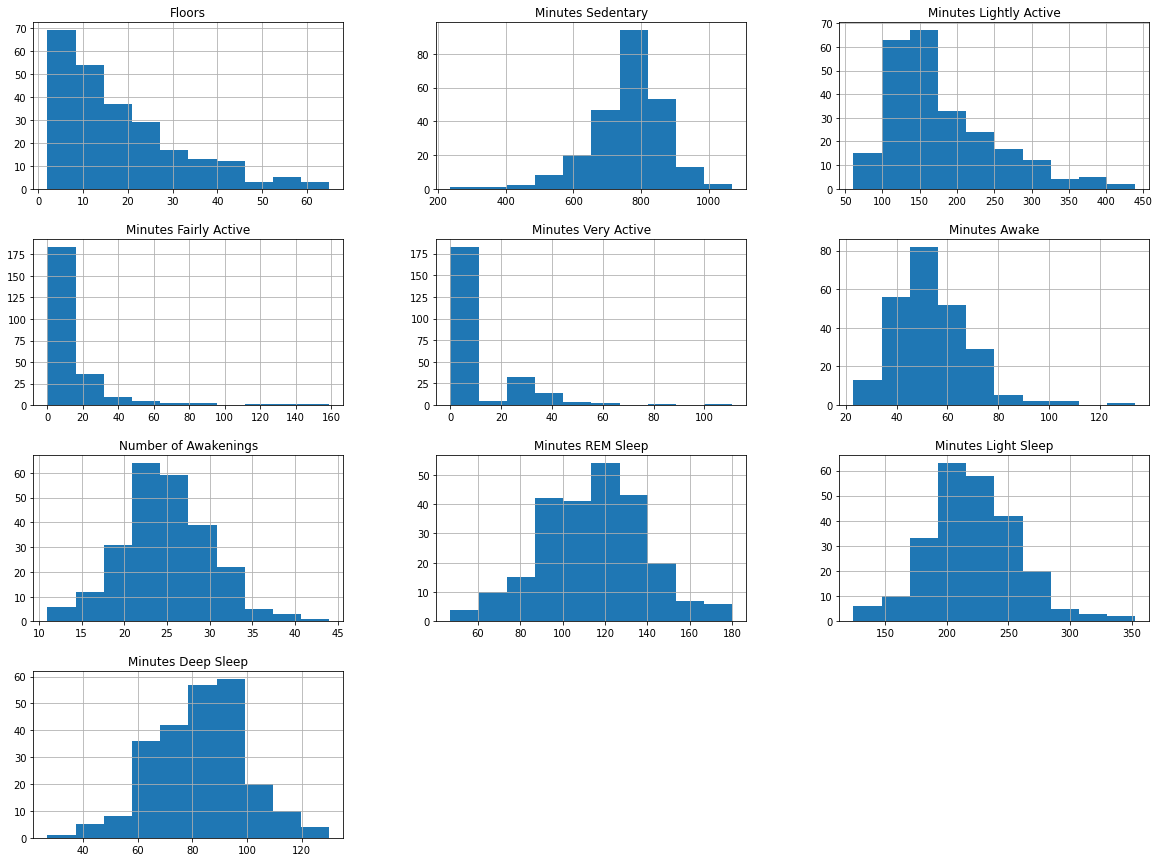

In [462]:
interest_data.hist(figsize=(20,15))

array([[<AxesSubplot:title={'center':'Floors'}>,
        <AxesSubplot:title={'center':'Minutes Lightly Active'}>]],
      dtype=object)

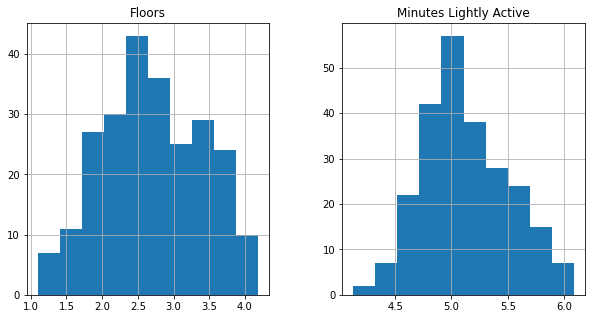

In [463]:
skewed = ['Floors', 'Minutes Lightly Active']
interest_data[skewed] = np.log(interest_data[skewed]+1)
interest_data[skewed].hist(figsize=(10,5))

### Scaling
For this project I'll be using PCA to reduce the dimensionality and be able to feed to another model, I'll talk more in the next section about the models, but in this case a scaling is needed and we dot it with the Sklearn library to scale the information accordingly. I'll verify that everything is scaled with another round of histograms.

array([[<AxesSubplot:title={'center':'Floors'}>,
        <AxesSubplot:title={'center':'Minutes Sedentary'}>,
        <AxesSubplot:title={'center':'Minutes Lightly Active'}>],
       [<AxesSubplot:title={'center':'Minutes Fairly Active'}>,
        <AxesSubplot:title={'center':'Minutes Very Active'}>,
        <AxesSubplot:title={'center':'Minutes Awake'}>],
       [<AxesSubplot:title={'center':'Number of Awakenings'}>,
        <AxesSubplot:title={'center':'Minutes REM Sleep'}>,
        <AxesSubplot:title={'center':'Minutes Light Sleep'}>],
       [<AxesSubplot:title={'center':'Minutes Deep Sleep'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

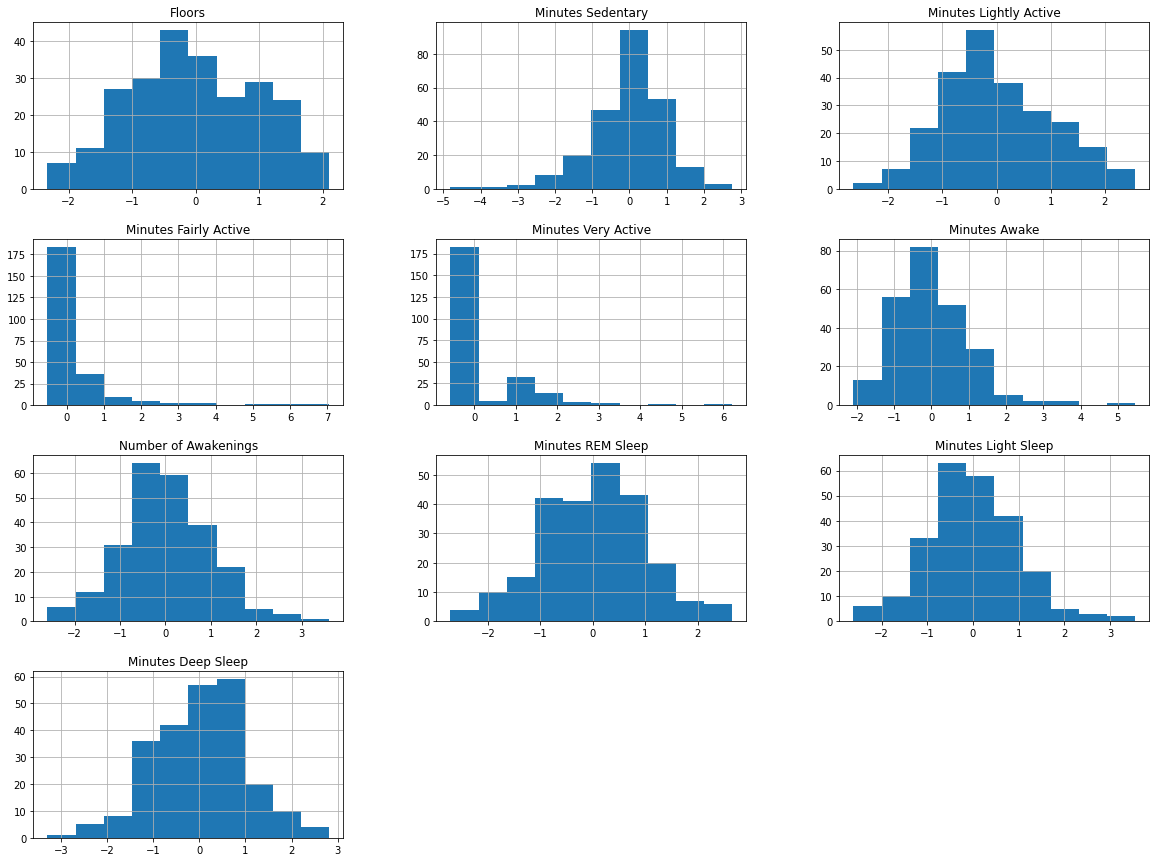

In [464]:
scaler = StandardScaler().fit(interest_data)
interest_data_scaled = scaler.transform(interest_data)
pd.DataFrame(interest_data_scaled, columns=interest_data.columns).hist(figsize=(20,15))

## Models
### PCA for Dimensionality Reduction
For this part I'll be doing a PCA to reduce the dimensionality of the problem. In this case we see to achieve a 75% of explained variance we need to have at least 5 Principal Components, but due to limitations I'll be focusing on the first 2 to graphically plot and use the capabilities of plotly to plot a 3rd PC.

In [465]:
pca = PCA(n_components=0.75).fit(interest_data_scaled)
reduced = pca.transform(interest_data_scaled)
pca.explained_variance_ratio_


array([0.28237744, 0.19814076, 0.13938699, 0.1182421 , 0.07565552])

In [466]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(reduced, x=0, y=1, color=target ,title='Principal Component Analysis')
fig.update_layout(
    xaxis_title="PC1",
    yaxis_title="PC2"
)

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.show()

From this graph, we can see the principal components and to this chart we're adding the target* we created previously. The results were somewhat expected but something we see here is how achieving Deep Sleep is somewhat related to the minutes of activity, but that is not all. Sleeping more than 7 hours is not defined either by activity or sedentary behaviours.

**Colors may vary but if color = 1 this is a point where I slept more than 7 hours.*

Lets try to add another PC to see if we maintain these two boundaries.

In [467]:
total_var = pca.explained_variance_ratio_[:3].sum()*100

fig = px.scatter_3d(
    reduced, x=0, y=1, z=2, color=target,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

### KMeans Clustering
With the dimensionality reduction ready lets see how how the clustering model acts in this scenario to find out if it segregates the data as expected or returns other insights regarding the reduced dimension set.

First we have to tune the hyperparameters of the `KMeans` clustering module in order to find a separation that could be ideal for this exercise.

In [468]:
kmeans = KMeans()
params = {
    'n_clusters': [2, 3, 4, 5],
    'n_init': [10, 12, 14, 16, 18, 20],
    'algorithm': ['lloyd', 'elkan']
}
clf = GridSearchCV(kmeans, param_grid=params, cv=4, scoring='neg_root_mean_squared_error')
clf.fit(reduced, target)

print('Best Score:', clf.best_score_)
print('Best Parameters:', clf.best_params_)

Best Score: -0.6609054803640807
Best Parameters: {'algorithm': 'lloyd', 'n_clusters': 2, 'n_init': 14}


In [469]:
kmeans = clf.best_estimator_.fit(reduced)
fig = px.scatter(reduced, x=0, y=1, color=kmeans.labels_, title='K-Means Clustering')
fig.update_layout(
    xaxis_title="PC1",
    yaxis_title="PC2"
)
fig.show()

The model found two clusters which seems to be based on the activity. On the right side we have the vectors which represent higher levels of activity such as minutes active, deep sleep, floors, etc. while on the left side we find inactivity vectors, mostly inactive minutes throughout the day.

The model found these two clusters but what about our previous PCA where we saw other clusters regarding sleeping more than 7 hours? My hypothesis is that if I add those two additional clusters we might see them again in this k means algorithm so lets add up those clusters we know are there to see what the model predicts.

In [470]:
kmeans = KMeans(n_clusters=4, n_init=16, algorithm='lloyd').fit(reduced)
fig = px.scatter(reduced, x=0, y=1, color=kmeans.labels_, title='K-Means Clustering')
fig.update_layout(
    xaxis_title="PC1",
    yaxis_title="PC2"
)
fig.show()

In [471]:
fig = px.scatter_3d(
    reduced, x=0, y=1, z=2, color=kmeans.labels_,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

## Analysis
After completing the models we can see that four clusters we can differentiate two without an issue but a 3rd and 4th conflict between them. Looking into the PCA vectors I can say that when I have a low activity we can easily distinguish between the "> 7 hrs of sleep" and the "< 7 hrs of sleep" much more easily. The issue arises once we look into the activity zone, the model has a hard time defining the sleep patterns when one has had a high activity scores.

The model in the end helped me to develop insights on my sleep behaviours and how my daily activities impact them, but I'd need to remember that these principal components only explain about 50% of the variance which in this case I'd like to consider them as a good measure of variance since personal sleep is something that is really hard to control with schedules and every-day work-life occassions which could easily alter these patterns.

## Conclusion
The unsupervised models achieved the goals but showed that more data in this case features would be good to create a much more precise model. In my case I'd be interested to see if having other health measurements such as avg. heart rate, glucose, stress levels, etc. can improve the model and help me identify the key factors to achieve a great night of sleep.

Hyperparameter tunning was minimal due to the nature of the data and the expectations of the project, the insights retrieved were mostly from the PCA to find which features impacted the most on the principal components and helped identify tendencies within the data.

Clustering cannot be dismissed as is, in this case we had a "target" but clustering was helpful to identify other feature relationships and where we need to input more and more information to go deeper into the model.

I'll continue gathering my sleep information to see in the long term if this analysis is enought o improve my future well-being or if the explained variance is too low for this project to explain my behaviour as of August 2022, you can keep track of this project on GitHub.

## References
How do I export my Fitbit account data? (n.d.). Fitbit | How do I export my Fitbit account data? Retrieved August 15, 2022, from https://help.fitbit.com/articles/en_US/Help_article/1133.htm?Highlight=TCX%20file

PCA visualization in Python. (n.d.). Plotly. Retrieved August 15, 2022, from https://plotly.com/python/pca-visualization/

sklearn.cluster.KMeans — scikit-learn 1.1.2 documentation. (n.d.). Scikit-learn KMeans. Retrieved August 15, 2022, from https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

sklearn.decomposition.PCA — scikit-learn 1.1.2 documentation. (n.d.). Scikit-learn PCA. Retrieved August 15, 2022, from https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html